In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# 1️. Load EV CSV
ev_path = r"C:\Users\Administrator\v2g\ACN_sessions_clean.csv"
ev_df = pd.read_csv(ev_path)

In [3]:
# 2️. Convert timestamps to datetime
ev_df["connectionTime"] = pd.to_datetime(ev_df["connectionTime"])
ev_df["disconnectTime"] = pd.to_datetime(ev_df["disconnectTime"])

In [4]:
# 3️. Compute session duration in hours
ev_df["duration_h"] = (ev_df["disconnectTime"] - ev_df["connectionTime"]).dt.total_seconds() / 3600

In [5]:
# 4️. Compute average charging power (kW)
ev_df["power_kw"] = ev_df["kWhDelivered"] / ev_df["duration_h"]

In [6]:
# 5️. Set connectionTime as index and round to nearest 15-min
ev_df = ev_df.set_index("connectionTime")
ev_df.index = ev_df.index.round("15min")

In [7]:
# 6️. Aggregate duplicate timestamps by summing energy and averaging power
ev_df = ev_df.groupby(ev_df.index).agg({
    "kWhDelivered": "sum",
    "power_kw": "mean"
})

In [8]:
# 7️. Resample to 15-minute intervals (ensure continuous time series)
ev_15min = ev_df.resample("15min").interpolate(method='time')

In [9]:
# 8️. Scale columns between 0 and 1
scaler = MinMaxScaler()
ev_15min[["energy_scaled", "power_scaled"]] = scaler.fit_transform(ev_15min[["kWhDelivered", "power_kw"]])

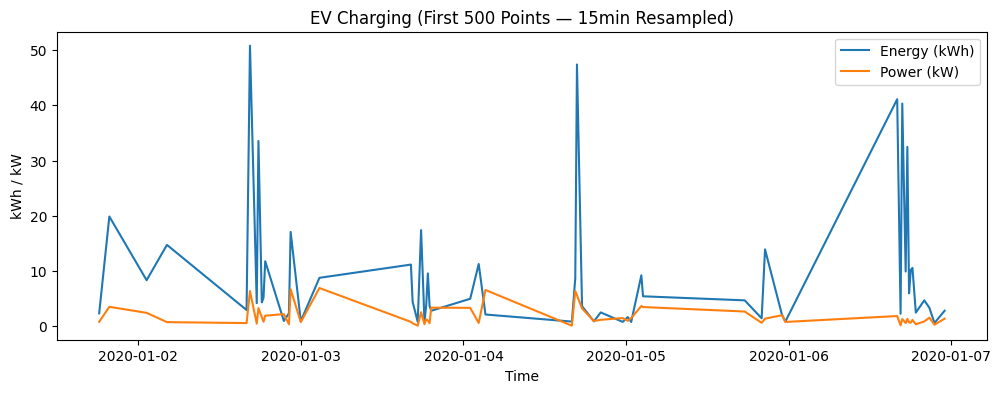

In [10]:
# 9️. Plot first 500 points
plt.figure(figsize=(12,4))
plt.plot(ev_15min["kWhDelivered"][:500], label="Energy (kWh)")
plt.plot(ev_15min["power_kw"][:500], label="Power (kW)")
plt.title("EV Charging (First 500 Points — 15min Resampled)")
plt.xlabel("Time")
plt.ylabel("kWh / kW")
plt.legend()
plt.show()

In [11]:
# 10. Save cleaned 15-minute EV dataset
ev_clean_path = r"C:\Users\Administrator\v2g\clean_ev_data_15min.csv"
ev_15min.to_csv(ev_clean_path)
print("Saved cleaned EV data to:", ev_clean_path)

Saved cleaned EV data to: C:\Users\Administrator\v2g\clean_ev_data_15min.csv


In [12]:
print(ev_df.head())
print(ev_df.index.min(), ev_df.index.max())

                     kWhDelivered  power_kw
connectionTime                             
2020-01-01 18:15:00         2.328  0.797716
2020-01-01 19:45:00        19.868  3.518882
2020-01-02 01:15:00         8.336  2.425998
2020-01-02 04:15:00        14.731  0.743917
2020-01-02 16:00:00         2.938  0.574767
2020-01-01 18:15:00 2021-09-14 02:00:00


In [13]:
print(ev_df.index.duplicated().sum())

0


In [14]:
print(ev_15min.head(20))
print(ev_15min.isna().sum())

                     kWhDelivered  power_kw  energy_scaled  power_scaled
connectionTime                                                          
2020-01-01 18:15:00      2.328000  0.797716       0.015848      0.002631
2020-01-01 18:30:00      5.251333  1.251243       0.041206      0.004166
2020-01-01 18:45:00      8.174667  1.704771       0.066564      0.005700
2020-01-01 19:00:00     11.098000  2.158299       0.091922      0.007235
2020-01-01 19:15:00     14.021333  2.611827       0.117280      0.008770
2020-01-01 19:30:00     16.944667  3.065354       0.142637      0.010304
2020-01-01 19:45:00     19.868000  3.518882       0.167995      0.011839
2020-01-01 20:00:00     19.343818  3.469206       0.163448      0.011671
2020-01-01 20:15:00     18.819636  3.419529       0.158901      0.011503
2020-01-01 20:30:00     18.295455  3.369853       0.154355      0.011335
2020-01-01 20:45:00     17.771273  3.320176       0.149808      0.011167
2020-01-01 21:00:00     17.247091  3.270500       0

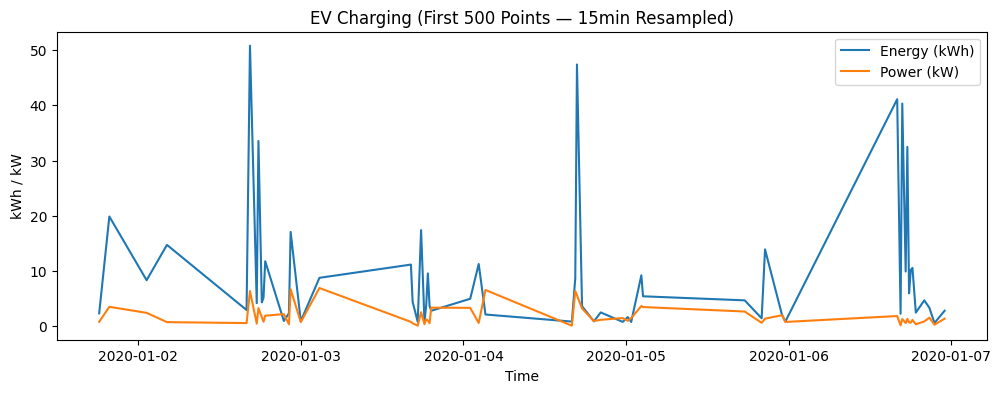

In [15]:
plt.figure(figsize=(12,4))
plt.plot(ev_15min["kWhDelivered"].replace(0, np.nan)[:500], label="Energy (kWh)")
plt.plot(ev_15min["power_kw"].replace(0, np.nan)[:500], label="Power (kW)")
plt.title("EV Charging (First 500 Points — 15min Resampled)")
plt.xlabel("Time")
plt.ylabel("kWh / kW")
plt.legend()
plt.show()
